In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


In [4]:
import lightgbm as lgb
#check lightgbm
try :
    import lightgbm as lgb
    HAS_LGB=True
except :
    HAS_LGB=False

print("has Lgb",HAS_LGB)

has Lgb True


In [5]:
train_df=pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
test_df=pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")
train_df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [6]:
print(train_df.isnull().sum())
print(train_df.shape)
print(train_df.describe)

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64
(593994, 13)
<bound method NDFrame.describe of             id  annual_income  debt_to_income_ratio  credit_score  \
0            0       29367.99                 0.084           736   
1            1       22108.02                 0.166           636   
2            2       49566.20                 0.097           694   
3            3       46858.25                 0.065           533   
4            4       25496.70                 0.053           665   
...        ...            ...                   ...           ...   
593989  593989       23004.26                 0.152           703   
593990  593990       35289.43                 0.10

In [7]:
numeric=train_df.select_dtypes(include=['int64','float64'])
print(list(numeric))

['id', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_paid_back']


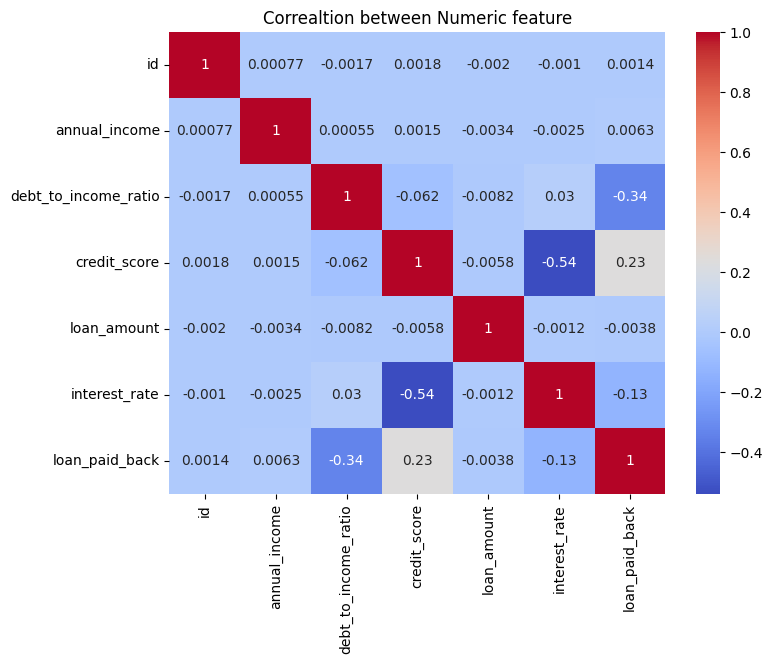

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
corr=numeric.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.title("Correaltion between Numeric feature")
plt.show()

In [9]:
categoric=train_df.select_dtypes('object')
bool_f=train_df.select_dtypes('bool')
print(list(categoric))
print(list(bool_f))

['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
[]


In [30]:
for c in categoric:
    if c in train_df.columns:
        print(c,':',train_df[c].nunique())
        print(c,':',train_df[c].unique())

gender : 3
gender : ['Female' 'Male' 'Other']
marital_status : 4
marital_status : ['Single' 'Married' 'Divorced' 'Widowed']
education_level : 5
education_level : ['High School' "Master's" "Bachelor's" 'PhD' 'Other']
employment_status : 5
employment_status : ['Self-employed' 'Employed' 'Unemployed' 'Retired' 'Student']
loan_purpose : 8
loan_purpose : ['Other' 'Debt consolidation' 'Home' 'Education' 'Vacation' 'Car'
 'Medical' 'Business']
grade_subgrade : 30
grade_subgrade : ['C3' 'D3' 'C5' 'F1' 'D1' 'D5' 'C2' 'C1' 'F5' 'D4' 'C4' 'D2' 'E5' 'B1'
 'B2' 'F4' 'A4' 'E1' 'F2' 'B4' 'E4' 'B3' 'E3' 'B5' 'E2' 'F3' 'A5' 'A3'
 'A1' 'A2']


In [11]:
def feature_engineering(df):
    df=df.copy()
    df["loan_to_income_ratio"] = df["loan_amount"] / df["annual_income"]
    df["interest_burden"] = df["loan_amount"] * df["interest_rate"] / 100
    df["credit_utilization"] = df["loan_amount"] / (df["credit_score"] + 1)
    df["income_per_debt_ratio"] = df["annual_income"] * (1 - df["debt_to_income_ratio"])
    df["income_minus_loan"] = df["annual_income"] - df["loan_amount"]
    df["loan_income_interaction"] = df["loan_amount"] * df["loan_to_income_ratio"]
    df["credit_burden"] = df["credit_score"] / (1 + df["debt_to_income_ratio"])

    
    def subgrade_to_numeric(subgrade):
        grade_letter = subgrade[0]
        sub_num = int(subgrade[1])
        grade_base = {'A': 0, 'B': 5, 'C': 10, 'D': 15, 'E': 20, 'F': 25, 'G': 30}
        return grade_base[grade_letter] + sub_num

    df["grade_score"] = df["grade_subgrade"].apply(subgrade_to_numeric)

    return df

train=feature_engineering(train_df)
test=feature_engineering(test_df)
print(train.shape)
print(test.shape)
    

(593994, 21)
(254569, 20)


In [12]:
train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,...,grade_subgrade,loan_paid_back,loan_to_income_ratio,interest_burden,credit_utilization,income_per_debt_ratio,income_minus_loan,loan_income_interaction,credit_burden,grade_score
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,...,C3,1.0,0.086094,345.635014,3.430692,26901.07884,26839.57,217.682848,678.966790,13
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,...,D3,0.0,0.207757,593.428520,7.210518,18438.08868,17514.92,954.249526,545.454545,18
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,...,C5,1.0,0.343080,1659.702640,24.467842,44758.27860,32561.05,5834.119350,632.634458,15
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,...,F1,1.0,0.099929,753.879280,8.768689,43812.46375,42175.77,467.913739,500.469484,26
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,...,D1,1.0,0.477883,1244.030303,18.294940,24145.37490,13312.27,5822.727428,631.528965,16


In [13]:
original_cols=set(train_df.columns)
new_cols = [col for col in train.columns if col not in original_cols]
print( new_cols)
print(len(new_cols))


['loan_to_income_ratio', 'interest_burden', 'credit_utilization', 'income_per_debt_ratio', 'income_minus_loan', 'loan_income_interaction', 'credit_burden', 'grade_score']
8


In [14]:
id_col='id'
target_col='loan_paid_back'
numeric_features = ['annual_income', 'debt_to_income_ratio', 'credit_score',
                    'loan_amount', 'interest_rate'] + new_cols

categorical_features = ['gender', 'marital_status', 'education_level',
                        'employment_status', 'loan_purpose', 'grade_subgrade']

features=numeric_features + categorical_features
print(numeric_features)
print(categorical_features)
print(features)

['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_to_income_ratio', 'interest_burden', 'credit_utilization', 'income_per_debt_ratio', 'income_minus_loan', 'loan_income_interaction', 'credit_burden', 'grade_score']
['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_to_income_ratio', 'interest_burden', 'credit_utilization', 'income_per_debt_ratio', 'income_minus_loan', 'loan_income_interaction', 'credit_burden', 'grade_score', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score


In [16]:
# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # missing value fill
    ('scaler', StandardScaler())   # scale to 0 mean, 1 std
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # missing value fill
    ('encoder', OneHotEncoder(handle_unknown='ignore',sparse_output=False))    # convert category to numbers
])


In [17]:
preprocessor=ColumnTransformer(
    transformers=[
        ('num',numeric_transformer,numeric_features),
        ('cat',categorical_transformer,categorical_features)
    ])

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

if HAS_LGB:
    model_lgb = LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.03,
        num_leaves=50,
        colsample_bytree=0.8,
        subsample=0.8,
        reg_alpha=0.1,
        reg_lambda=0.2,
        min_child_samples=25,
        random_state=42,
        class_weight='balanced' 
    )
else:
    model_lgb = RandomForestClassifier(
        n_estimators=300,
        max_depth=14,
        random_state=42,
        class_weight='balanced'
    )

# Random Forest classifier
model_rgb = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    class_weight='balanced'
)

# Pipeline setup
pipe_lgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model_lgb)
])

pipe_rgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model_rgb)
])

# --- Training ---
print("TRAINING LIGHTGBM MODEL >>>")
pipe_lgb.fit(train[features], train[target_col])

print("TRAINING RANDOM FOREST MODEL >>>")
pipe_rgb.fit(train[features], train[target_col])


TRAINING LIGHTGBM MODEL >>>
[LightGBM] [Info] Number of positive: 474494, number of negative: 119500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3200
[LightGBM] [Info] Number of data points in the train set: 593994, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
TRAINING RANDOM FOREST MODEL >>>


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['annual_income',
                                                   'debt_to_income_ratio',
                                                   'credit_score',
                                                   'loan_amount',
                                                   'interest_rate',
                                                   'loan_to_income_ratio',
                                                   'interest_burden',
                                                   'credit_utilization',
                                                   'income_per_debt_ratio',
                                                   'income_minus_loa...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'marital_status',
                                                   'education_level',
                                                   'employment_status',
                                                   'loan_purpose',
                                                   'grade_subgrade'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=12,
                                        n_estimators=200, random_state=42))])

In [19]:
pred_lgb=pipe_lgb.predict_proba(test[features])[:,1]
pred_rgb=pipe_rgb.predict_proba(test[features])[:,1]
final_pred=0.65*pred_lgb + 0.35*pred_rgb
final_pred=np.clip(final_pred,0,1)

In [20]:
model=pipe_lgb

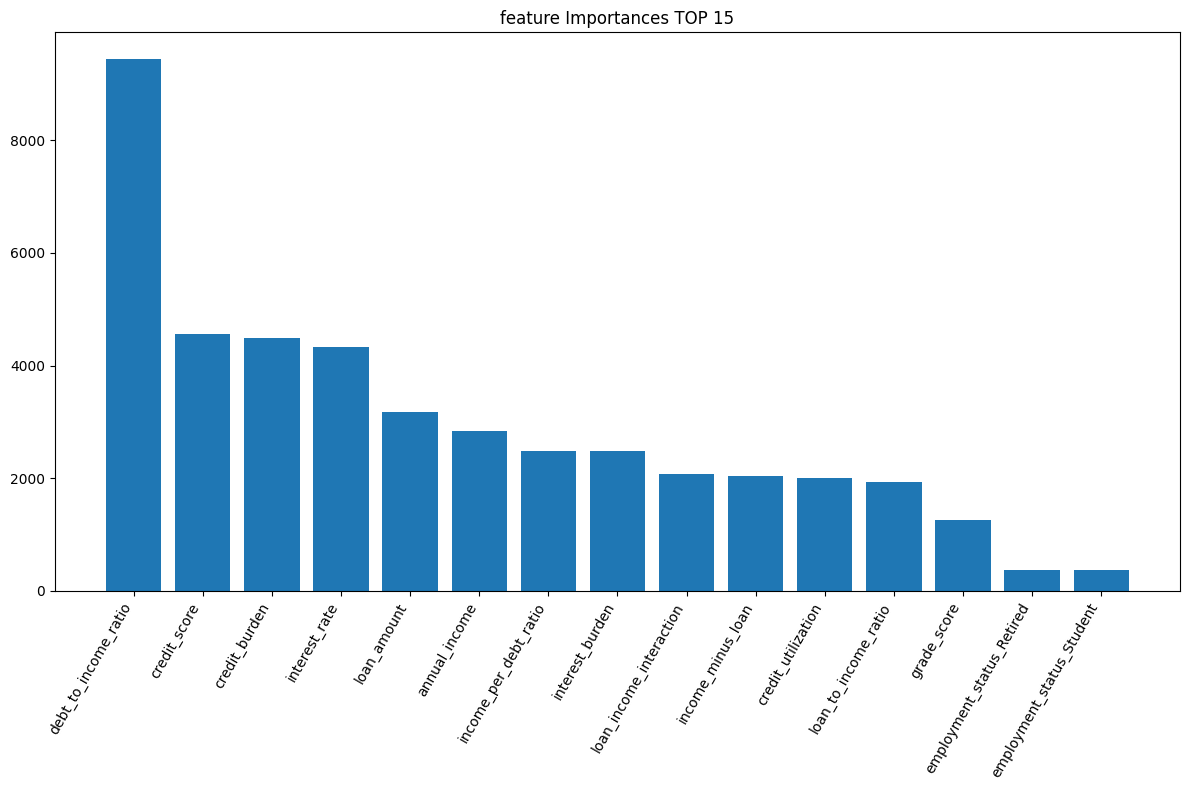

In [21]:
num_f=numeric_features
cat_f=list(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features))
feature_names=num_f + cat_f
importances=model.named_steps['model'].feature_importances_
indices=np.argsort(importances)[::-1]
plt.figure(figsize=(12,8))
plt.title("feature Importances TOP 15")
plt.bar(range(15),importances[indices[:15]])
plt.xticks(range(15),[feature_names[i] for i in indices[:15]],rotation=60,ha='right')
plt.tight_layout()
plt.show()

In [22]:
top_features = [(feature_names[i], importances[i]) for i in indices[:15]]
for f, imp in top_features:
    print(f"{f:35s}  {imp:.4f}")

debt_to_income_ratio                 9442.0000
credit_score                         4562.0000
credit_burden                        4488.0000
interest_rate                        4337.0000
loan_amount                          3180.0000
annual_income                        2839.0000
income_per_debt_ratio                2489.0000
interest_burden                      2480.0000
loan_income_interaction              2073.0000
income_minus_loan                    2035.0000
credit_utilization                   1996.0000
loan_to_income_ratio                 1933.0000
grade_score                          1255.0000
employment_status_Retired            375.0000
employment_status_Student            368.0000


In [23]:

submission=pd.DataFrame({
    'id' :test['id'].astype(int),
    'loan_paid_back' :final_pred
    
})
submission.to_csv('submission.csv',index=False)
print('submission_created')

submission_created


In [24]:
import joblib

joblib.dump(pipe_lgb, 'pipe_lgb.pkl')
joblib.dump(pipe_rgb, 'pipe_rgb.pkl')
joblib.dump(features, 'features_list.pkl')

['features_list.pkl']

In [31]:
import sklearn

print(sklearn.__version__)
print(np.__version__)
print(pd.__version__)


1.2.2
1.26.4
2.2.3
